# Coding and visualising the model

We can take our difference equation and use it directly to plot the sizes of the different SIR compartments.

In [1]:
# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Coding the difference equations

First we define the increments $\Delta S$, $\Delta I$, and $\Delta R$ as functions of the previous sizes of the compartments. These functions taken the compartment sizes *now* and return the increment (or decrement) that should be applied to each compartment to get to the *next* timestep. This kind of *higher-order* function &ndash; functions that return functions, that can then be passed around to *other* functions before they're called &ndash; is a very useful programming technique when you want to do lots of automation.

In [2]:
def make_sir(pInfect, pRemove):
    '''Create difference equations.
    
    :param pInfect: infection probability per contact
    :param rRemove: removal (recovery) probability
    :returns: a triple of difference equations  for S, I, and R
    '''
    
    # turn the equations into update functions
    def deltaS(S, I, R):
        return -pInfect * S * I
    def deltaI(S, I, R):
        return pInfect * S * I - pRemove * I
    def deltaR(S, I, R):
        return pRemove * I
    
    # return the three functions
    return (deltaS, deltaI, deltaR)

Using these functions we can define a simulation function. This takes several parameters:

- the number of timesteps to simulate
- the size of the population
- the initial infection probability
- the probability of infcection at each contact
- the probability of recovery

These are used to create the difference functions and the initial conditions for the system. The functions are then "pushed" through the time series. At each step, the last values of the compartment sizes are used to compute increments, which are then applied to those values to create the next values.

In [3]:
def epidemic_sir(T, N, pInfected, pInfect, pRemove):
    '''Run an epidemic.
    
    :param T: model time
    :param N: total population size
    :param pInfected: initial infected population
    :param pInfect: infection probability per contact
    :param pRemove: removal (recovery) probability
    :returns: a tuple of timesteps, S, I, and R sizes as time series
    '''
    
    # create the change functions for these parameters
    (deltaS, deltaI, deltaR) = make_sir(pInfect, pRemove)
    
    # initial conditions
    sss = [ N * (1.0 - pInfected) ]
    iss = [ N * pInfected ] 
    rss = [ 0 ] 

    # push the initial conditions through the equations
    for t in range(1, T):
        # apply the change functions to the sub-populations of 
        # the previous timestep to compute the changes
        ds = deltaS(sss[-1], iss[-1], rss[-1])
        di = deltaI(sss[-1], iss[-1], rss[-1])
        dr = deltaR(sss[-1], iss[-1], rss[-1])
        
        # the value at the next timestep are those at the
        # previous timestep plus the value of the change
        # in that value
        sss.append(sss[-1] + ds)
        iss.append(iss[-1] + di)
        rss.append(rss[-1] + dr)
        
    # return the time series
    return (list(range(0, T)), sss, iss, rss)

We get back a tuple of four time series, holding the timesteps and compartment sizes.

## Plotting compartment sizes

We can then set up some experiments. We set some "fixed" parameters for population, initial infection and removal probabilities, and then set up a sequence of infection probabilities that we'll use in the model.

In [4]:
# simulation parameters
N = 1000
T = 5000

# SIR parameters (fixed)
pInfected = 0.01
pRemove = 0.001

# range of SIR pInfect values to model
pInfects = [ 0.0000010, 0.0000020, 0.0000035,
             0.0000040, 0.0000050, 0.0000080 ]

"Running" these equations to produce graphs of compartment sizes over time is simply a matter of creating, for each infection probability of interest, a model of that system that produces time series for us to plot.

For simplicity we plot the S and I sizes, and omit the R size: it's easy to add if you'd like to see it (just add another `plot` command).

We plot the various values of infection probability in their own sub-plots, and label them accordingly. We try to avoid over-labelling, since that gets distracting, so we only put axes labels "round the outside" of the set of plots.

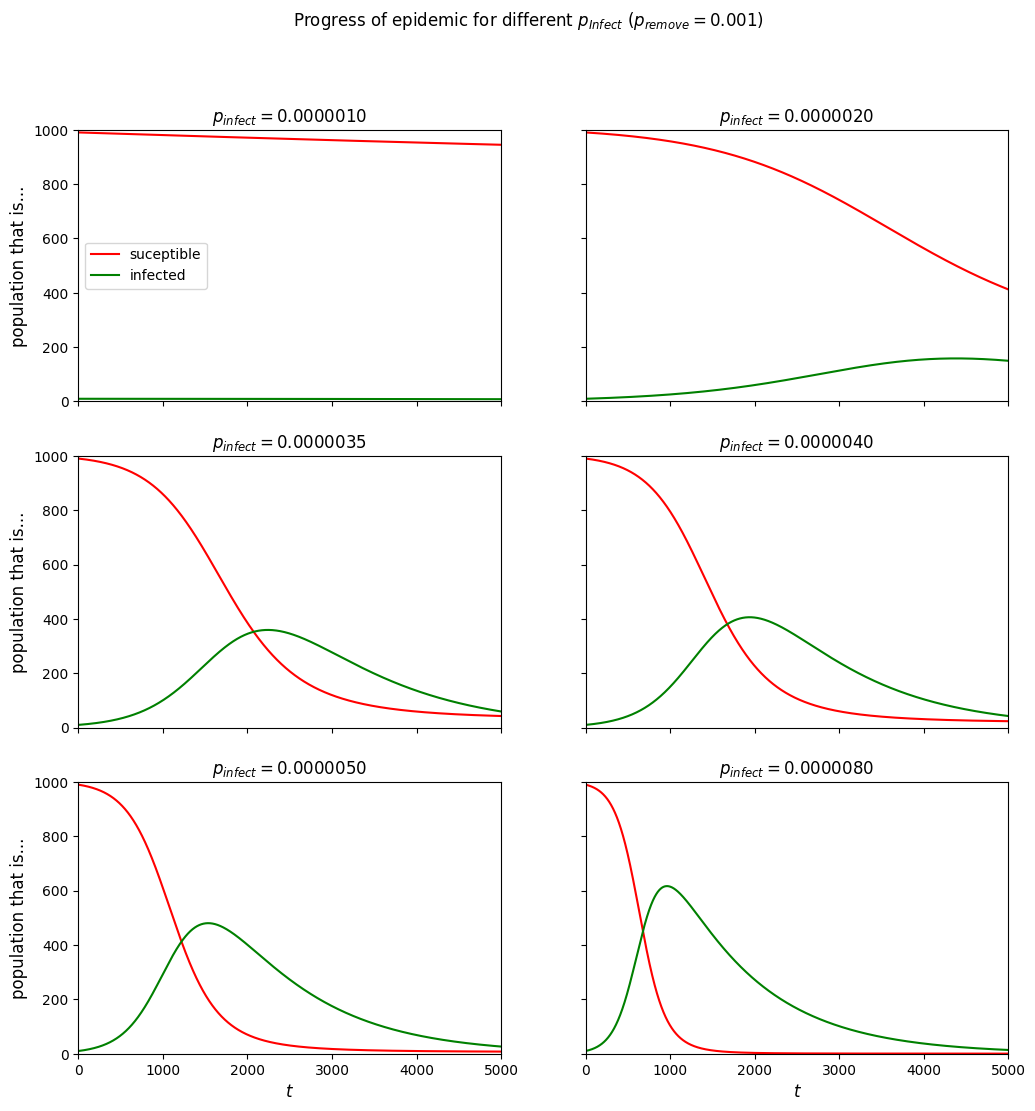

In [5]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True,
                          figsize=(12, 12))

# draw the sub-plots for the selected values of pInfect
for i in range(6):
    pInfect = pInfects[i]
    ax = axs[int(i / 2)][i % 2]
    (ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
    
    # draw the graph in the sub-plot
    ax.plot(ts, sss, 'r-', label='suceptible')
    ax.plot(ts, iss, 'g-', label='infected')
    
    # set title and axis limits
    ax.set_title('$p_{\\mathit{infect}} = ' + '{b:.7f}$'.format(b=pInfect))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    
# fine-tune the figure
plt.suptitle('Progress of epidemic for different $p_{\\mathit{Infect}}$ ($p_{remove} = ' + '{a}$)'.format(a=pRemove))
for i in [0, 1, 2]:
    axs[i][0].set_ylabel('population that is...')
for i in[0, 1]:
    axs[2][i].set_xlabel('$t$')
axs[0][0].legend(loc='center left')
plt.show()

## Re-using the data

Having collected the data,w e can re-use it in other ways. Let's for example plot the cumulative number of people who've been infected as the outbreak progresses. This is complementary information ot the compartment sizes, which show the number of people *currently* infected at any time &ndash; which in turn might be useful in deciding, for example, whether there will be enough hospital beds available at the "peak" of infections. Cumulative infections, by contrast, tells us how many people in the population either *are or have been* infected.

How can we compute this? The easiest way is to remember the formulation we used for the S compartment's size:

$$
\Delta S = -p_{\mathit{infect}} S I
$$

The minus sign shows that the compartment is monotonically emptying. But we also know that all the individuals who *leave* S *enter* I, so summing this difference will show us how the number of people infected overall changes with time. We can compute this by saying that the number of people infected at $t = 0$ is given by the iniitial infection probability, and at each step the number of people newly infected is given by the difference between the number of people who *were* suscedptible in the previous timestep and the number people who *are* susceptible in this timestep &ndash; since they've all become infected.

There are other ways to calculate this time series, but this way has the advantage of re-using the code we've already written.

We can compute the cumulative time series from the ones we computed using the epidemic modelling function, and plot it similarly to above. To indicate that it's an integral, we'll also fill-in the area below the curve.

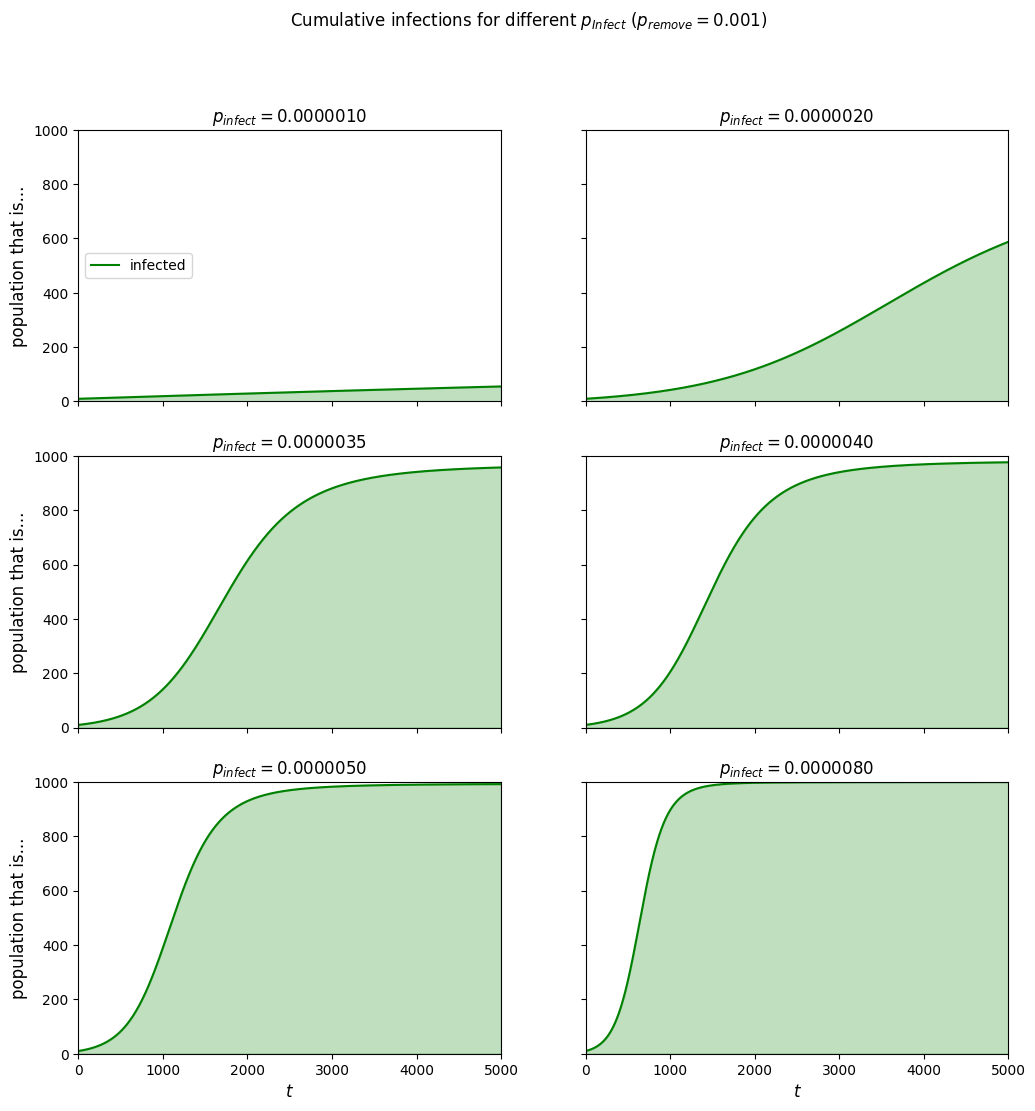

In [6]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True,
                          figsize=(12, 12))

# draw the sub-plots for the selected values of pInfect
for i in range(6):
    pInfect = pInfects[i]
    ax = axs[int(i / 2)][i % 2]
    (ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
        
    # compute the cumulative infections as the sum of the
    # individuals leaving the susceptible compartment
    cis = [ iss[0] ]
    for t in range(1, T):
        cis.append(cis[-1] + (sss[t - 1] - sss[t]))
    
    # draw the graph in the sub-plot
    ax.plot(ts, cis, 'g-', label='infected')
    
    # set title and axis limits
    ax.set_title('$p_{\\mathit{infect}} = ' + '{b:.7f}$'.format(b=pInfect))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    
    # fill beneath the curve
    ax.fill_between(ts, [ 0 ] * T, cis, color='g', alpha=0.25)
    
# fine-tune the figure
plt.suptitle('Cumulative infections for different $p_{\\mathit{Infect}}$ ($p_{remove} = ' + '{a}$)'.format(a=pRemove))
for i in [0, 1, 2]:
    axs[i][0].set_ylabel('population that is...')
for i in[0, 1]:
    axs[2][i].set_xlabel('$t$')
axs[0][0].legend(loc='center left')
plt.show()

These models aren't really simulations *per se*: rather, they're numerical calculations applied to a set of difference equations. (The approach for differential equations is similar.)